Source: https://github.com/abachaa/VQA-Med-2019

In [2]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import tensorflow as tf
from tensorflow import keras
from sentence_transformers import SentenceTransformer
import nlpaug.augmenter.word as naw
import nltk

config = tf.compat.v1.ConfigProto(gpu_options = 
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
# device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

stopwords = set(nltk.corpus.stopwords.words('english'))
aug = naw.SynonymAug(aug_src='wordnet', stopwords=stopwords)
sbert_model = SentenceTransformer('distilbert-base-nli-mean-tokens')

1 Physical GPUs, 1 Logical GPUs


In [3]:
import os
import json
import random
from typing import List

import cv2
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
seed = 42

In [5]:
train_val_set = {
    'train': {},
    'val': {},
}

df = pd.read_csv('train_val.csv')

for key in ['id', 'category', 'question', 'answer', 'part']:
    df[key] = df[key].str.lower().str.strip()

categories = set(df['category'].unique())
cat_map = dict([(cat, idx) for (idx, cat) in enumerate(categories)])
cat_map_rev = dict([(idx, cat) for (idx, cat) in enumerate(categories)])

answers = set(df['answer'].unique())
answers_map = dict([(a, idx) for (idx, a) in enumerate(answers)])
answers_map_rev = dict([(idx, a) for (idx, a) in enumerate(answers)])

# prepare text data

def augment_df(
    df: pd.DataFrame,
    aug_loops: int = 0,
    col: str = 'question',
    key_skip=None
) -> pd.DataFrame:
    records = df.to_dict('records')
    augmented = []
    
    count = len(records)
    
    augment = aug.augment
    augmented_add = augmented.append
    for (row_idx, row) in enumerate(records):
        print(f'\rAugmenting {row_idx + 1} / {count}', end='')
        if key_skip(row):
            continue
        for _ in range(aug_loops):
            new_row = row.copy()
            new_row[col] = augment(str(row[col]))
            augmented_add(new_row)
    print('')
    records.extend(augmented)
    return pd.DataFrame(records)

def create_embedding(arr: List[str], key=None):
    if key is None:
        res = sbert_model.encode(arr)
    else:
        res = sbert_model.encode([key(x) for x in arr])
    res = res.reshape(len(res), 64, 12)
    res = np.array(res, dtype=np.float64)
    return res

def avg(arr, round_key=lambda x: x):
    return round_key(sum(arr) / len(arr))

name_labels_map = {}
for (row_idx, row) in df.iterrows():
    name = row['id']
    cat = row['category']
    assert(cat in categories), 'unknown category in df'    
    if name not in name_labels_map:
        name_labels_map[name] = set()
    name_labels_map[name].add(cat)


def get_part(_df, part: str) -> List[dict]:
    res = _df[_df['part'] == part]
    res = shuffle(res, random_state=seed)
    res = res.to_dict('records')
    return res

augdf = augment_df(df, key_skip=lambda x: x['part'] == 'val')
train = get_part(augdf, 'train')
val = get_part(augdf, 'val')

print('Encoding data')
for part in [train, val]:
    for (idx, elem) in enumerate(part):
        txt = [elem['question']]
        part[idx]['embedding'] = create_embedding(txt)[0]

print('Finished encoding data')


Augmenting 14792 / 14792
Encoding data


Finished encoding data


In [6]:

def map_arr(key, _part):
    return [key(v) for v in _part]

def split_it(_part, train_key='embedding', test_key='answer'):
    x = map_arr(lambda x: x[train_key], _part)
    y = map_arr(lambda x: x[test_key], _part)
    y = [answers_map[x] for x in y]
    return np.array(x, dtype=np.float32), np.array(y, dtype=np.int32)

X_train_txt, y_train_answer = split_it(train)
X_test_txt, y_test_answer = split_it(val)


In [15]:
# load images into memory
image_map = {}
image_folder = os.path.join('.', 'images')

image_shapes = []
average_shape = None
downsample_val = 4

# get all image shapes to find the average shape
for filename in os.listdir(image_folder):
    image_path = os.path.join(image_folder, filename)
    image_shapes.append(cv2.imread(image_path).shape)

x, y, z = [avg(v, round) for v in zip(*image_shapes)]
average_shape = (x//downsample_val, y//downsample_val, z)
print(f'{average_shape=}')


average_shape=(174, 168, 3)


In [16]:
width, height, color_range = average_shape

for filename in os.listdir(image_folder):
    image_path = os.path.join(image_folder, filename)
    name, _ = os.path.splitext(os.path.basename(image_path))
    image_map[name] = cv2.imread(image_path)    
    image_map[name] = cv2.resize(image_map[name], (width, height))
    image_map[name] = np.array(image_map[name])

In [17]:
def split_it_image(_part, train_key='id', test_key='category'):
    x = map_arr(lambda x: x[train_key], _part)
    x = [image_map[_id] for _id in x]
    y = map_arr(lambda x: x[test_key], _part)
    y = [cat_map[k] for k in y]
    return np.array(x), np.array(y, dtype=np.int32)

X_train_img, y_train_cat = split_it_image(train)
X_test_img, y_test_cat = split_it_image(val)

In [18]:
img_input_shape = image_map[train[0]['id']].shape
txt_input_shape = train[0]['embedding'].shape
print(f'{img_input_shape=}; {txt_input_shape=}')
img_input_shape+txt_input_shape

img_input_shape=(168, 174, 3); txt_input_shape=(64, 12)


(168, 174, 3, 64, 12)

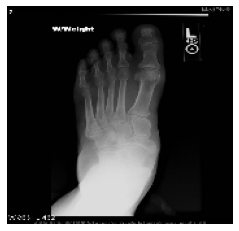

In [19]:
imf = image_map[list(image_map.keys())[random.randint(0, len(image_map.keys()))]]
plt.imshow(imf, cmap='binary')
plt.axis('off')
plt.show()

In [20]:
nb_classes = len(answers)
num_epochs = 10
input_shape = (img_input_shape, txt_input_shape)
print(f'{input_shape=}')

input_shape=((168, 174, 3), (64, 12))


In [21]:
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Reshape, concatenate, Flatten, Input
from tensorflow.keras.layers import Bidirectional, LSTM

from tensorflow.keras.applications.vgg16 import VGG16

# image model (w/ transfer learning)
input_img = VGG16(input_shape=img_input_shape, weights='imagenet', include_top=False)

for layer in input_img.layers:
    layer.trainable = False

x = Flatten()(input_img.output)
x = Dense(512)(x)
x = Dense(nb_classes, activation="softmax")(x)
x = Model(inputs=input_img.input, outputs=x)


# lang model
input_lang = Input(shape=txt_input_shape)
y = LSTM(512)(input_lang)
# y = Flatten()(y)
y = Dense(nb_classes, activation="softmax")(y)
y = Model(inputs=input_lang, outputs=y)

# combine lang and img models
combined = concatenate([x.output, y.output], axis=1)
z = Dense(nb_classes, activation="softmax")(combined)
model = Model(inputs=[x.input, y.input], outputs=z)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)


print(model.summary())

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 168, 174, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 168, 174, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 168, 174, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [22]:
print(f'{X_train_img.shape=}; {X_train_txt.shape=}')

model_history = model.fit(
    x=[X_train_img, X_train_txt],
    y=y_train_answer,
    epochs=num_epochs,
    validation_data=([X_test_img, X_test_txt], y_test_answer),
)

X_train_img.shape=(12792, 168, 174, 3); X_train_txt.shape=(12792, 64, 12)


2022-06-25 13:21:15.872229: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1121807232 exceeds 10% of free system memory.
2022-06-25 13:21:26.327900: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.04GiB (rounded to 1121807360)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-06-25 13:21:26.328086: W tensorflow/core/common_runtime/bfc_allocator.cc:491] *********************************************************************************____*****__***_____


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.